In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")      

**Background of Problem Statement :
NYC 311's mission is to provide the public with quick and easy access to all New York City government services and information while offering the best customer service. Each day, NYC311 receives thousands of requests related to several hundred types of non-emergency services, including noise complaints, plumbing issues, and illegally parked cars. These requests are received by NYC311 and forwarded to the relevant agencies such as the police, buildings, or transportation. The agency responds to the request, addresses it, and then closes it.**

***Problem Objective :
Perform service request data analysis on 311 calls in New York. Identify patterns in data as well as visualize the main types of complaints.***

**Analysis of Tasks to be performed**

**Read or convert the columns ‘Created Date’ and Closed Date’ to datetime datatype and create a new column ‘Request_Closing_Time’ as the time elapsed between request creation and request closing. 
Provide major insights/patterns that you can offer in a visual format (graphs or tables); at least 4 major conclusions that you can come up with after generic data mining.
Order the complaint types based on the average ‘Request_Closing_Time’, grouping them for different locations.
Perform a statistical test for the following:
For the statements below, you need to specify Null and Alternate and then provide a statistical test to accept or reject the Null Hypothesis along with the corresponding "p-value".**

**Whether the average response time across complaint types is similar or not (overall)?**

**Are the type of complaint or service requested and location related?**

In [2]:
# we read the data file and leave only those columns that will be useful in further analysis
data = pd.read_csv('../input/nyc-311-customer-service-requests-analysis/NYC311data.csv',parse_dates=['Created Date','Closed Date', 'Resolution Action Updated Date'])\
[['Unique Key','Created Date','Closed Date','Agency','Agency Name','Complaint Type','Descriptor','Location Type','Status','City','Resolution Action Updated Date']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      300698 non-null  int64         
 1   Created Date                    300698 non-null  datetime64[ns]
 2   Closed Date                     298534 non-null  datetime64[ns]
 3   Agency                          300698 non-null  object        
 4   Agency Name                     300698 non-null  object        
 5   Complaint Type                  300698 non-null  object        
 6   Descriptor                      294784 non-null  object        
 7   Location Type                   300567 non-null  object        
 8   Status                          300698 non-null  object        
 9   City                            298084 non-null  object        
 10  Resolution Action Updated Date  298511 non-null  datetim

In [3]:
data.isna().sum()

Unique Key                           0
Created Date                         0
Closed Date                       2164
Agency                               0
Agency Name                          0
Complaint Type                       0
Descriptor                        5914
Location Type                      131
Status                               0
City                              2614
Resolution Action Updated Date    2187
dtype: int64

In [4]:
data = data.rename(columns=lambda x: x.replace(' ', '_').lower()) # immediately convert to lowercase and replace spaces with underscores
data.loc[data['status'] != 'Closed', 'status'] = 'Closed' # the last date of the incident in the dataset is dated 2016-01-03, so the status of all events for today can be changed to "closed"
data['location_type'].fillna(value='Street/Sidewalk',inplace=True) # Some requests have gaps in the location. Since the events clearly took place on the street, we will assign the appropriate naming
data.loc[data['closed_date'].isna() == True,'closed_date'] = data['resolution_action_updated_date']

In [5]:
 data[(data['closed_date'].isna() & data['resolution_action_updated_date'].isna())].value_counts("complaint_type").head(5) 

complaint_type
Illegal Parking            829
Noise - Street/Sidewalk    532
Noise - Commercial         326
Blocked Driveway           231
Derelict Vehicle           129
dtype: int64

 Some requests do not have a completion date. Mostly complaints about noise and improper parking. They will also have to be removed from the dataset.

In [6]:
data.head(5)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,status,city,resolution_action_updated_date
0,32310363,2015-12-31 23:59:45,2016-01-01 00:55:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,NEW YORK,2016-01-01 00:55:00
1,32309934,2015-12-31 23:59:44,2016-01-01 01:26:00,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,Closed,ASTORIA,2016-01-01 01:26:00
2,32309159,2015-12-31 23:59:29,2016-01-01 04:51:00,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,Closed,BRONX,2016-01-01 04:51:00
3,32305098,2015-12-31 23:57:46,2016-01-01 07:43:00,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,Closed,BRONX,2016-01-01 07:43:00
4,32306529,2015-12-31 23:56:58,2016-01-01 03:24:00,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,Closed,ELMHURST,2016-01-01 03:24:00


In [7]:
data.dropna(subset=['closed_date', 'resolution_action_updated_date'], how='all',inplace=True)
data = data.loc[data['closed_date'] >= data['created_date']]
data.insert(3, 'request_Closing_Time', data['closed_date'] - data['created_date']) #create new column request closing time
data['request_Closing_Time'] = data['request_Closing_Time'].dt.seconds / 60 # convert to minutes
data.head(1)

,unique_key,created_date,closed_date,request_Closing_Time,agency,agency_name,complaint_type,descriptor,location_type,status,city,resolution_action_updated_date
0,32310363,2015-12-31 23:59:45,2016-01-01 00:55:00,55.25,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,NEW YORK,2016-01-01 00:55:00


In [8]:
data[data['closed_date'] < data['created_date']].shape[0] # no mistakes

0

In [9]:
data.groupby(['city','agency_name'],as_index= False).agg({'status': 'count'}).agency_name.value_counts() # all inquiries transferred to NYPD

New York City Police Department    53
NYPD                                1
Name: agency_name, dtype: int64

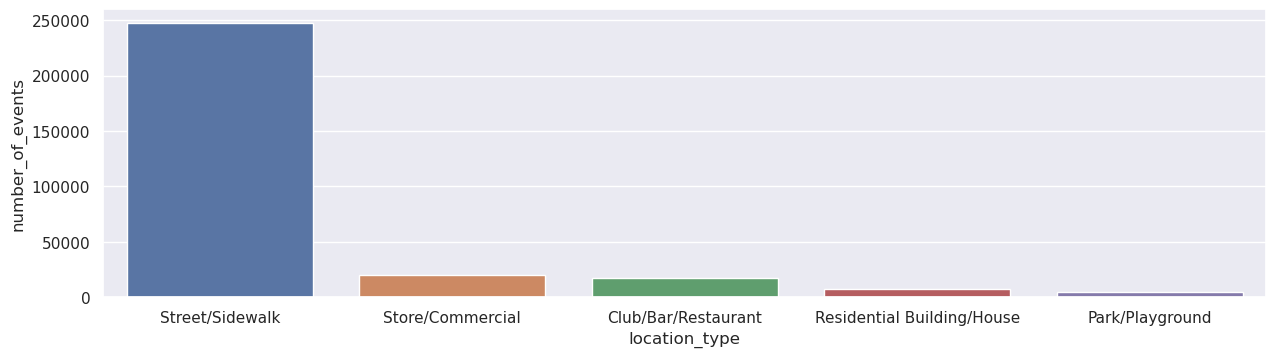

,location_type,number_of_events
13,Street/Sidewalk,247638
12,Store/Commercial,20184
1,Club/Bar/Restaurant,17229
10,Residential Building/House,6953
7,Park/Playground,4751


In [10]:
events = data.groupby('location_type', as_index=False).agg(number_of_events = ('status', 'count')).sort_values('number_of_events', ascending=False).head()

# Let's display the top 5 events that took place most often in all cities
sns.set(rc={"figure.figsize":(15, 6)})
ax = sns.barplot(data=events, x="location_type", y="number_of_events")
plt.subplots_adjust(bottom=0.4)
plt.show()

events

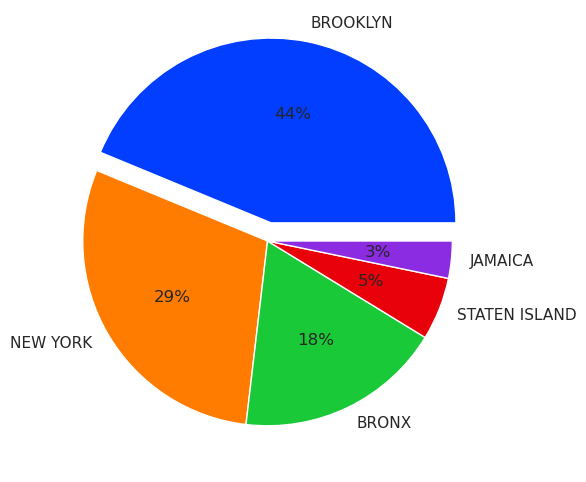

In [11]:
# Pie chart for top 5 cities with maximum complaints.
city = data.groupby(['city'],as_index= False).agg({'status': 'count'}).sort_values("status",ascending = False).head(5)
city_name  = city['city'].tolist()
data_count = city['status'].tolist()

# declaring exploding pie
explode = [0.1, 0, 0, 0, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
plt.pie(data_count, labels=city_name, colors=palette_color,
        explode=explode, autopct='%.0f%%')
plt.show()

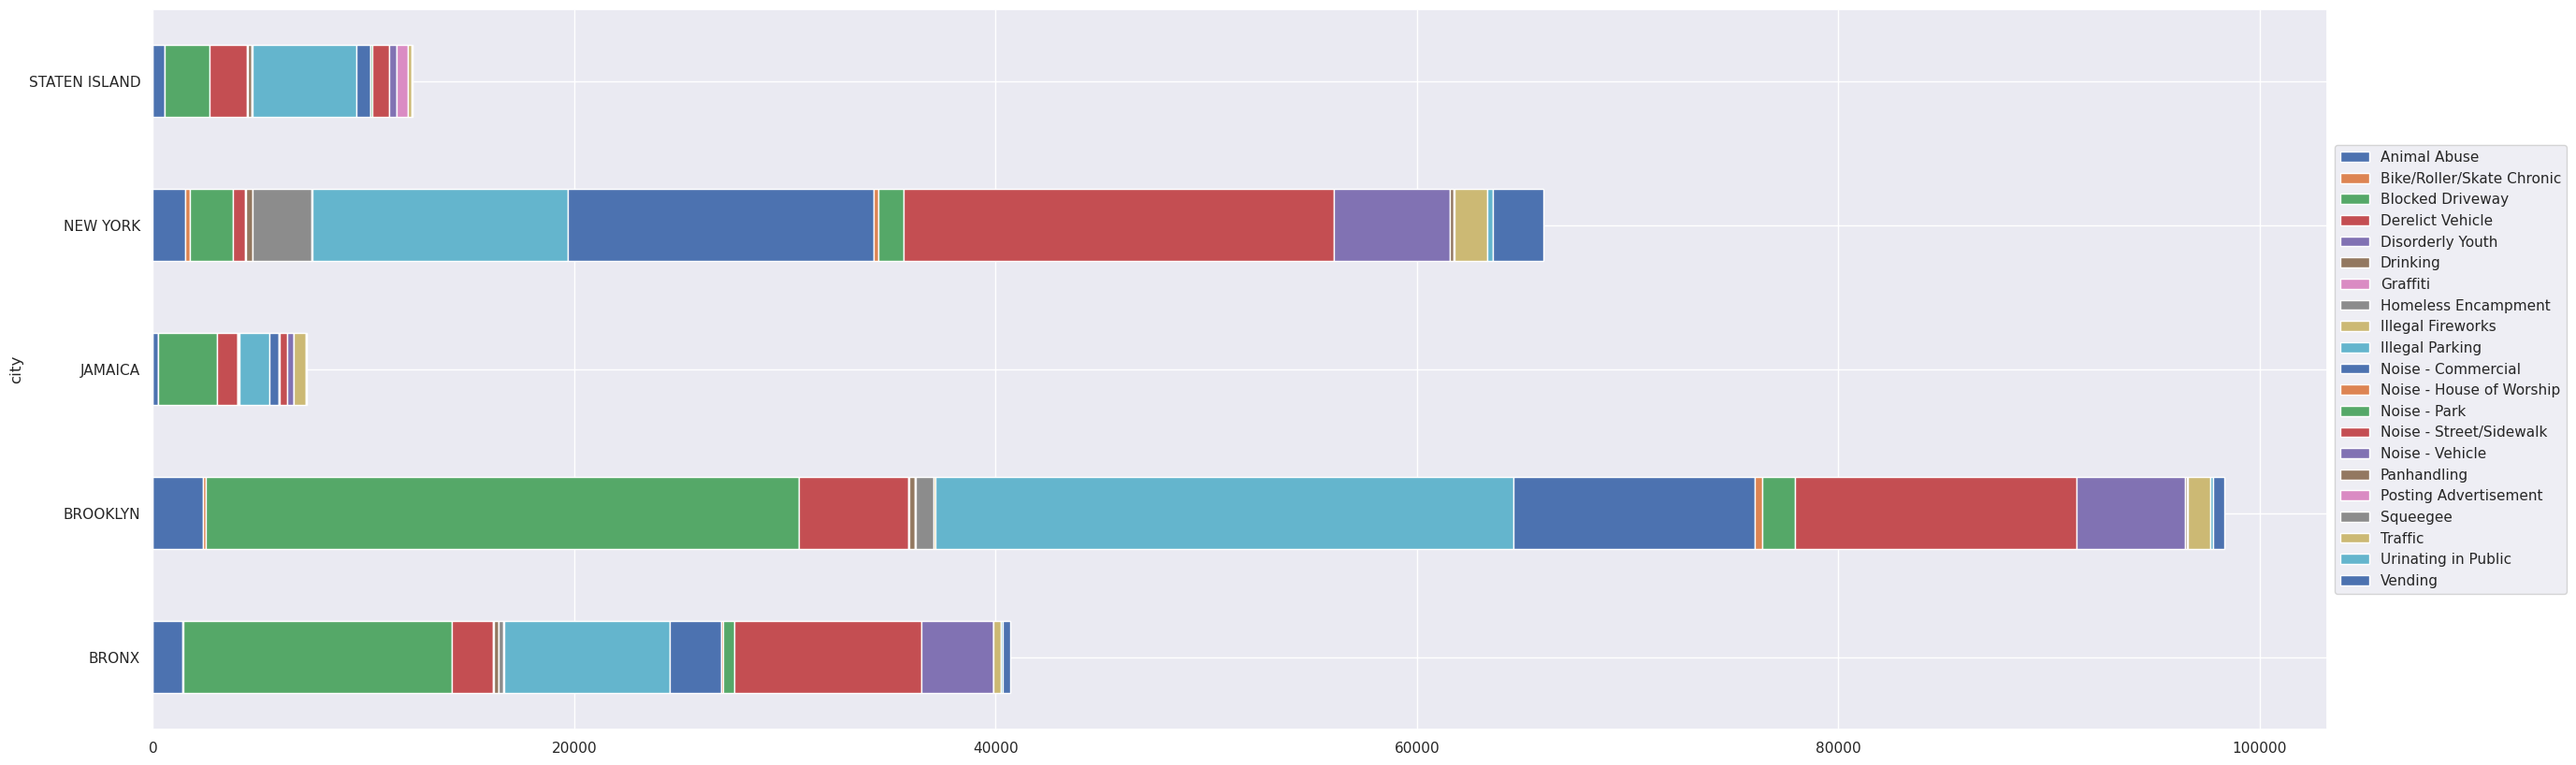

In [12]:
# Graph reflecting the relationship of events in the top 5 cities
data2= data.query("city in @city_name ")
data2 = pd.crosstab(data2['city'],data['complaint_type'])
ax = data2.plot.barh(figsize=(30,10), stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

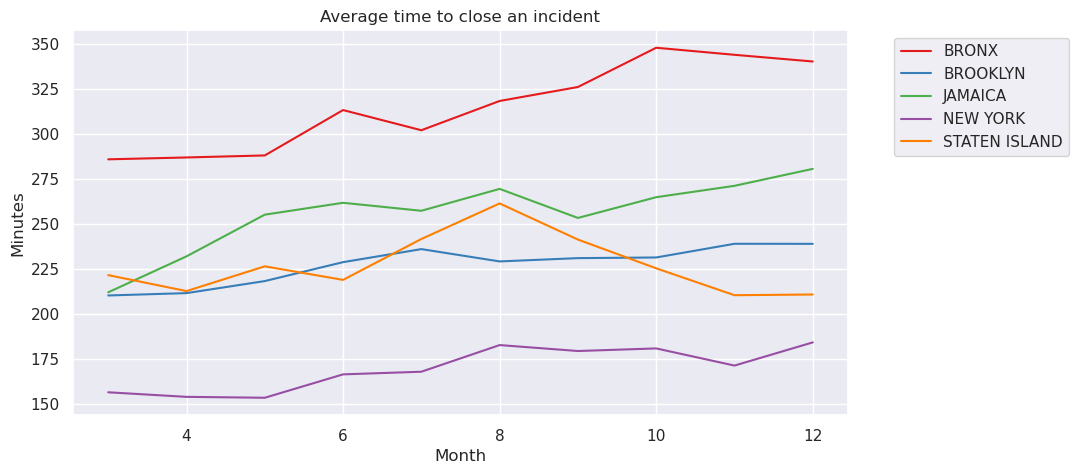

In [13]:
# Let's make another graph to understand how quickly the cities from the top 5 coped with interest in the last year
data['created_date_month'] = data['created_date'].dt.month
request_Closing_Time = data.query("city in @city_name").groupby(["city","created_date_month"],as_index=False)['request_Closing_Time'].mean()
plt.figure(figsize=(10, 5), dpi=100) 
sns.lineplot(data=request_Closing_Time, x="created_date_month", y="request_Closing_Time", hue="city", palette="Set1")
plt.title("Average time to close an incident")
plt.xlabel("Month")
plt.ylabel("Minutes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [14]:
# Order the complaint types based on the average ‘Request_Closing_Time’, grouping them for different locations.
data.groupby(["complaint_type"]).agg({"request_Closing_Time":"mean"}).sort_values(["request_Closing_Time"],ascending= False).head()

,request_Closing_Time
complaint_type,
Graffiti,339.871534
Derelict Vehicle,335.340399
Agency Issues,315.619444
Animal Abuse,277.573208
Blocked Driveway,263.077376


**Intermediate conclusion:**

- all inquiries transferred to NYPD.
- Most incidents occur on Street/Sidewalk.
- Nearly half of all resolved incidents are in Brooklyn.
- It is noticed that in the top 5 countries in terms of the number of all incidents, most complaints are related to: Blocked Driveway ; Illegal Parking ; Derelict Vehicle.
- Top 5 countries by the number of all incidents, closed each request at about the same time during the year, except for the city of bronx, the time increased there.

**Let's do a statistical test**

H0 hypothesis : the average response time for the types of complaints is the same.

H1 hypothesis : the average response time for the types of complaints not is the same. (we will get a statistically significant result if at least one sample mean is different from the others)

In [15]:
data2 = data[["request_Closing_Time","complaint_type"]]

In [16]:
model = smf.ols(formula = "request_Closing_Time ~ C(complaint_type)",data = data2).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(complaint_type),23.0,5.069145e+08,2.203976e+07,424.224961,0.0
Residual,298521.0,1.550906e+10,5.195300e+04,NaN,NaN


p - value of 0 (<0.5) mean we reject null hypothesis(i.e the average response time for the types of complaints is the same.).

Are the type of complaint or service requested and location related? - Chi-Square Test

Но - complaint type and location related

H1 - complaint type and location not related

In [17]:
stat, p, dof, expected = stats.chi2_contingency(pd.crosstab(data.location_type, data.complaint_type))
stat, p

(1626497.7592039844, 0.0)

p - value of 0 (<0.5) mean we reject null hypothesis(i.e complaint type and location related).